In [1]:

import pickle
import time
import logging
import numpy as np
import extra_data as ed
from copy import copy
import os
from scipy import optimize
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.optimize import least_squares
from scipy.optimize import curve_fit


import cv2

import matplotlib.pyplot as plt
from skimage import transform

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
plt.rcParams['text.usetex'] = True

%config InlineBackend.figure_format='retina'

In [2]:
def extraVISARImages_mean(exp_id, run_id):
    # exp_id = 900352  # Commisioning experiment
    # run_id = 184  # Streak camera calibration image run

    # Import run data and display info on run
    run = ed.open_run(exp_id, run_id)
    # run.info()
    # Determine first and last train ids
    first_train = run.train_ids[0]
    last_train = run.train_ids[-1]
    # print(f"First train ID: {first_train}")
    # print(f"Last train ID: {last_train}")

    # Create a mask for pandas df where no data exists
    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present:\n{indexes}")

    # # Select train ID for streak calibration
    # train_id = 1605832127
    # print(f'\nSelecting Train ID: {train_id}')

    # Raw data from streak camera image
    kep1 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_1:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )


    imgKEP1_r = np.mean(kep1[:, :, :], axis = 0)
    # Rotate image 90 degrees
    imgKEP1_r = cv2.rotate(imgKEP1_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    f = np.loadtxt('../VISAR_CalibrationFiles_latest/VISAR_KEPLER1_20nsWindow_p2740_run639_evt1_polynomial.cal', delimiter=',')
    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP1_r_dewarp = cv2.remap(
        imgKEP1_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )

    
    
    

    mask = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput", "data.image.pixels"].data_counts() != 0
    )

    # Create array for train IDs where data exists
    indexes = mask.to_numpy().nonzero() + first_train
    indexes_count = indexes.shape[1]
    # Total number of trains with data
    # print(f"{indexes_count} Train IDs with data present")


    kep2 = (
        run["HED_SYDOR_TEST/CAM/KEPLER_2:daqOutput"]["data.image.pixels"]
        .select_trains(ed.by_id[np.squeeze(indexes)])
        .ndarray()
    )

    imgKEP2_r = np.mean(kep2, axis = 0)
    imgKEP2_r = cv2.rotate(imgKEP2_r, cv2.ROTATE_90_COUNTERCLOCKWISE)
    
    
    # f = np.loadtxt('../../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run26_evt1_V2.cal', delimiter=',')
    # f = np.loadtxt('../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p2740_run1222_evt1_polynomial.cal', delimiter=',')
    f = np.loadtxt('../VISAR_CalibrationFiles_latest/VISAR_KEPLER2_20nsWindow_p900364_run14_evt1_polynomial.cal', delimiter=',')

    original_grid_Y_evt1 = f[:, 0]
    original_grid_X_evt1 = f[:, 1]

    cartesian_grid_Y_evt1 = f[:, 2]
    cartesian_grid_X_evt1 = f[:, 3]

    user_grid_evt1 = [(i, j) for (i, j) in zip(original_grid_Y_evt1, original_grid_X_evt1)]
    output_grid_evt1 = [(i, j) for (i, j) in zip(cartesian_grid_Y_evt1, cartesian_grid_X_evt1)]


    # load grid coordinates from file
    grid_1, grid_2 = np.mgrid[0:4095:4096j, 0:4095:4096j]
    grid_z = griddata(
        output_grid_evt1, user_grid_evt1, (grid_1, grid_2), method="linear"
    )  # used to visualize the coordinates on image
    map_1 = np.append([], [ar[:, 1] for ar in grid_z]).reshape(4096, 4096)
    map_2 = np.append([], [ar[:, 0] for ar in grid_z]).reshape(4096, 4096)
    map_1_32 = map_1.astype("float32")
    map_2_32 = map_2.astype("float32")
    

    imgKEP2_r_dewarp = cv2.remap(
        imgKEP2_r, map_1_32, map_2_32, cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE
    )
    
    return imgKEP1_r_dewarp, imgKEP2_r_dewarp

In [3]:
imgKEP1_bckg, imgKEP2_bckg  = extraVISARImages_mean(2740, 640)

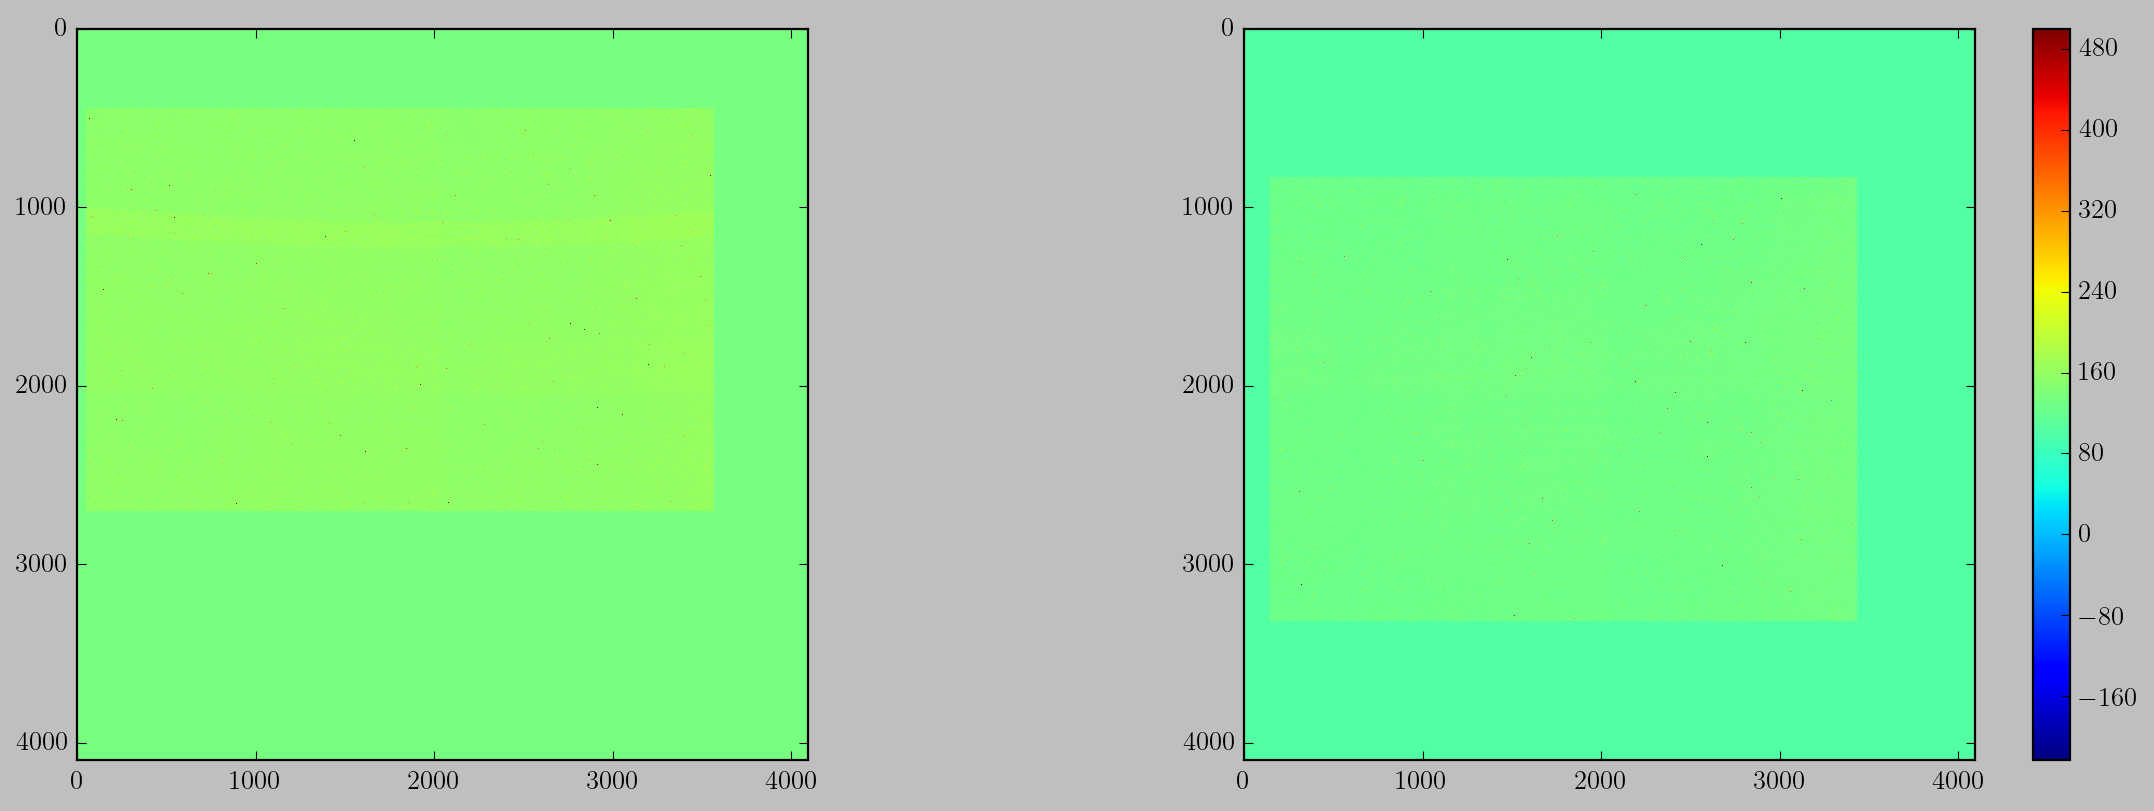

In [4]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_bckg, vmax = 500, cmap = plt.cm.jet)

plt.subplot(222)
plt.imshow(imgKEP2_bckg, vmax = 500, cmap = plt.cm.jet)
plt.colorbar()
plt.tight_layout()
plt.show()

In [5]:
imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(2740, 650)

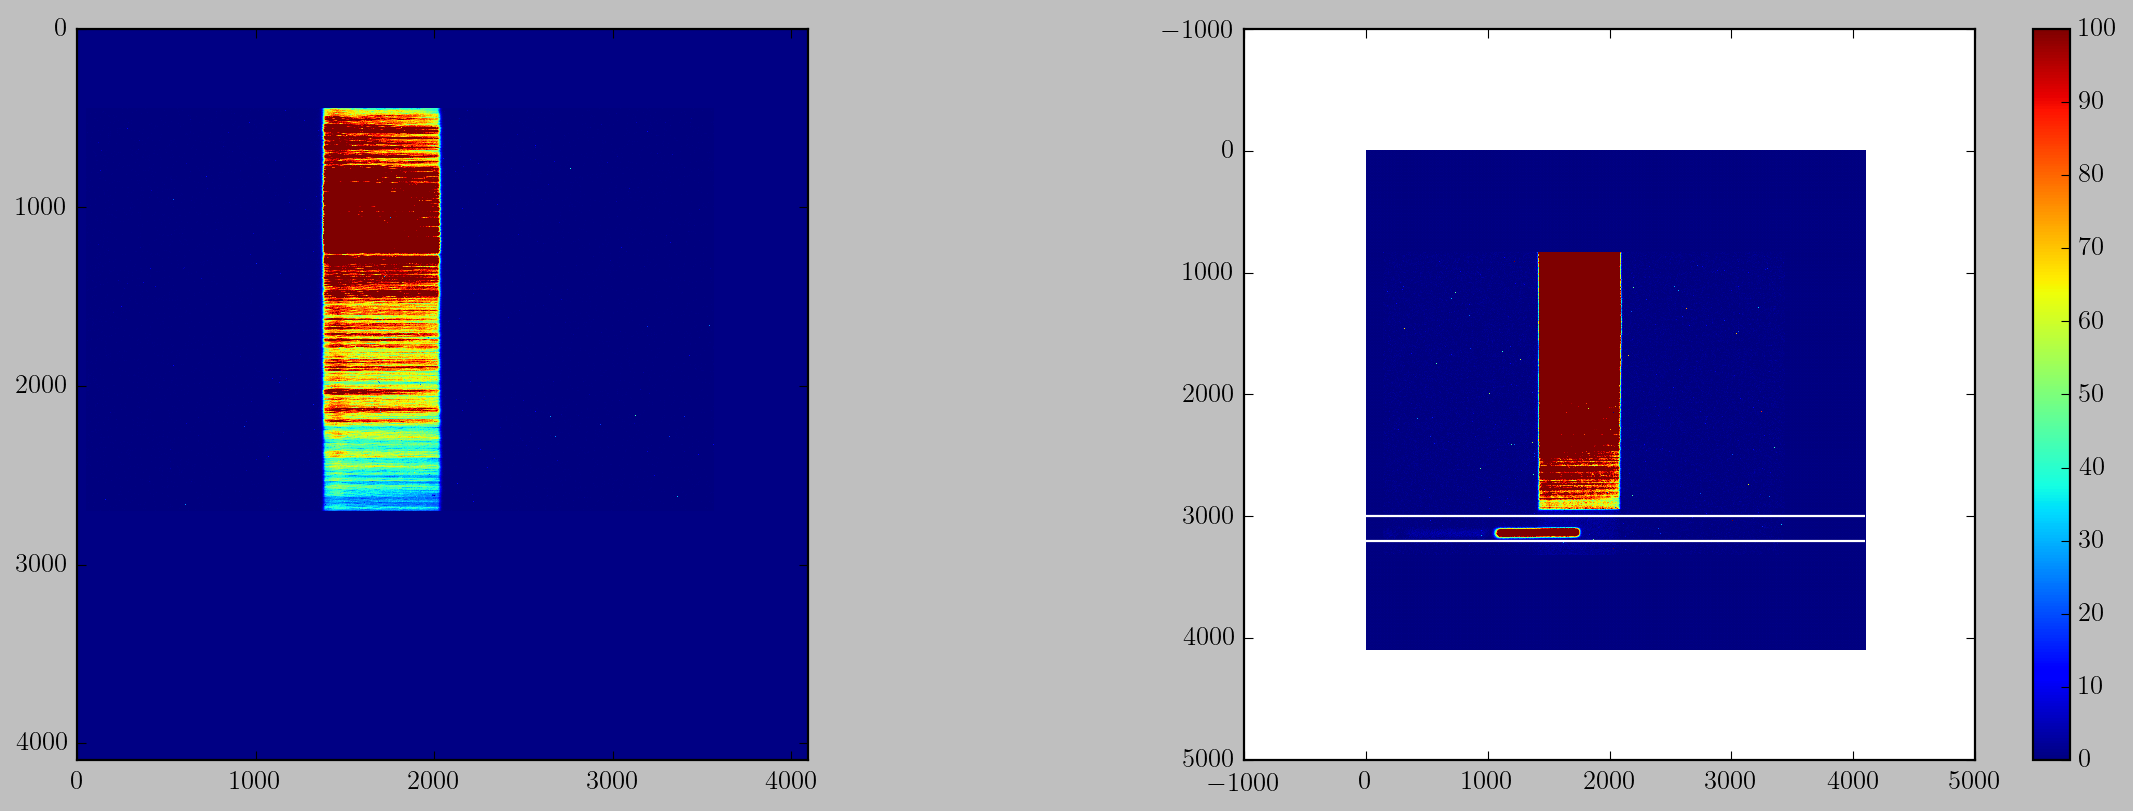

In [6]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_r-imgKEP1_bckg, vmin = 0, vmax = 500, cmap = plt.cm.jet)

plt.subplot(222)
plt.imshow(imgKEP2_r-imgKEP2_bckg, vmin = 0, vmax = 100, cmap = plt.cm.jet)
plt.hlines(3000, 0, 4095, color = 'w')
plt.hlines(3200, 0, 4095, color = 'w')
plt.colorbar()
plt.tight_layout()
plt.show()

In [7]:
lineoutFiducial_bckg_KEPLER1 = np.mean(imgKEP1_r[1000:2500, 500:3500], axis = 0)
lineoutFiducial_filter_bckg_KEPLER1 = gaussian_filter(lineoutFiducial_bckg_KEPLER1, 5)
lineoutFiducial_filter_1stDeriv_bckg_KEPLER1 = np.diff(lineoutFiducial_filter_bckg_KEPLER1)

positionRightEdgeFiducial_KEPLER1 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)
positionLeftEdgeFiducial_KEPLER1 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)

print(4096 - (500 + positionRightEdgeFiducial_KEPLER1)) # Because time goes right to left and we want time left to right for VISAR analysis so need to do 4096 - val

2069


In [8]:
lineoutFiducial_bckg_KEPLER2 = np.mean(imgKEP2_r[1000:2500, 500:3000], axis = 0)
lineoutFiducial_filter_bckg_KEPLER2 = gaussian_filter(lineoutFiducial_bckg_KEPLER2, 5)
lineoutFiducial_filter_1stDeriv_bckg_KEPLER2 = np.diff(lineoutFiducial_filter_bckg_KEPLER2)

positionRightEdgeFiducial_KEPLER2 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)
positionLeftEdgeFiducial_KEPLER2 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)

print(4096 - (500 + positionRightEdgeFiducial_KEPLER2))

2018


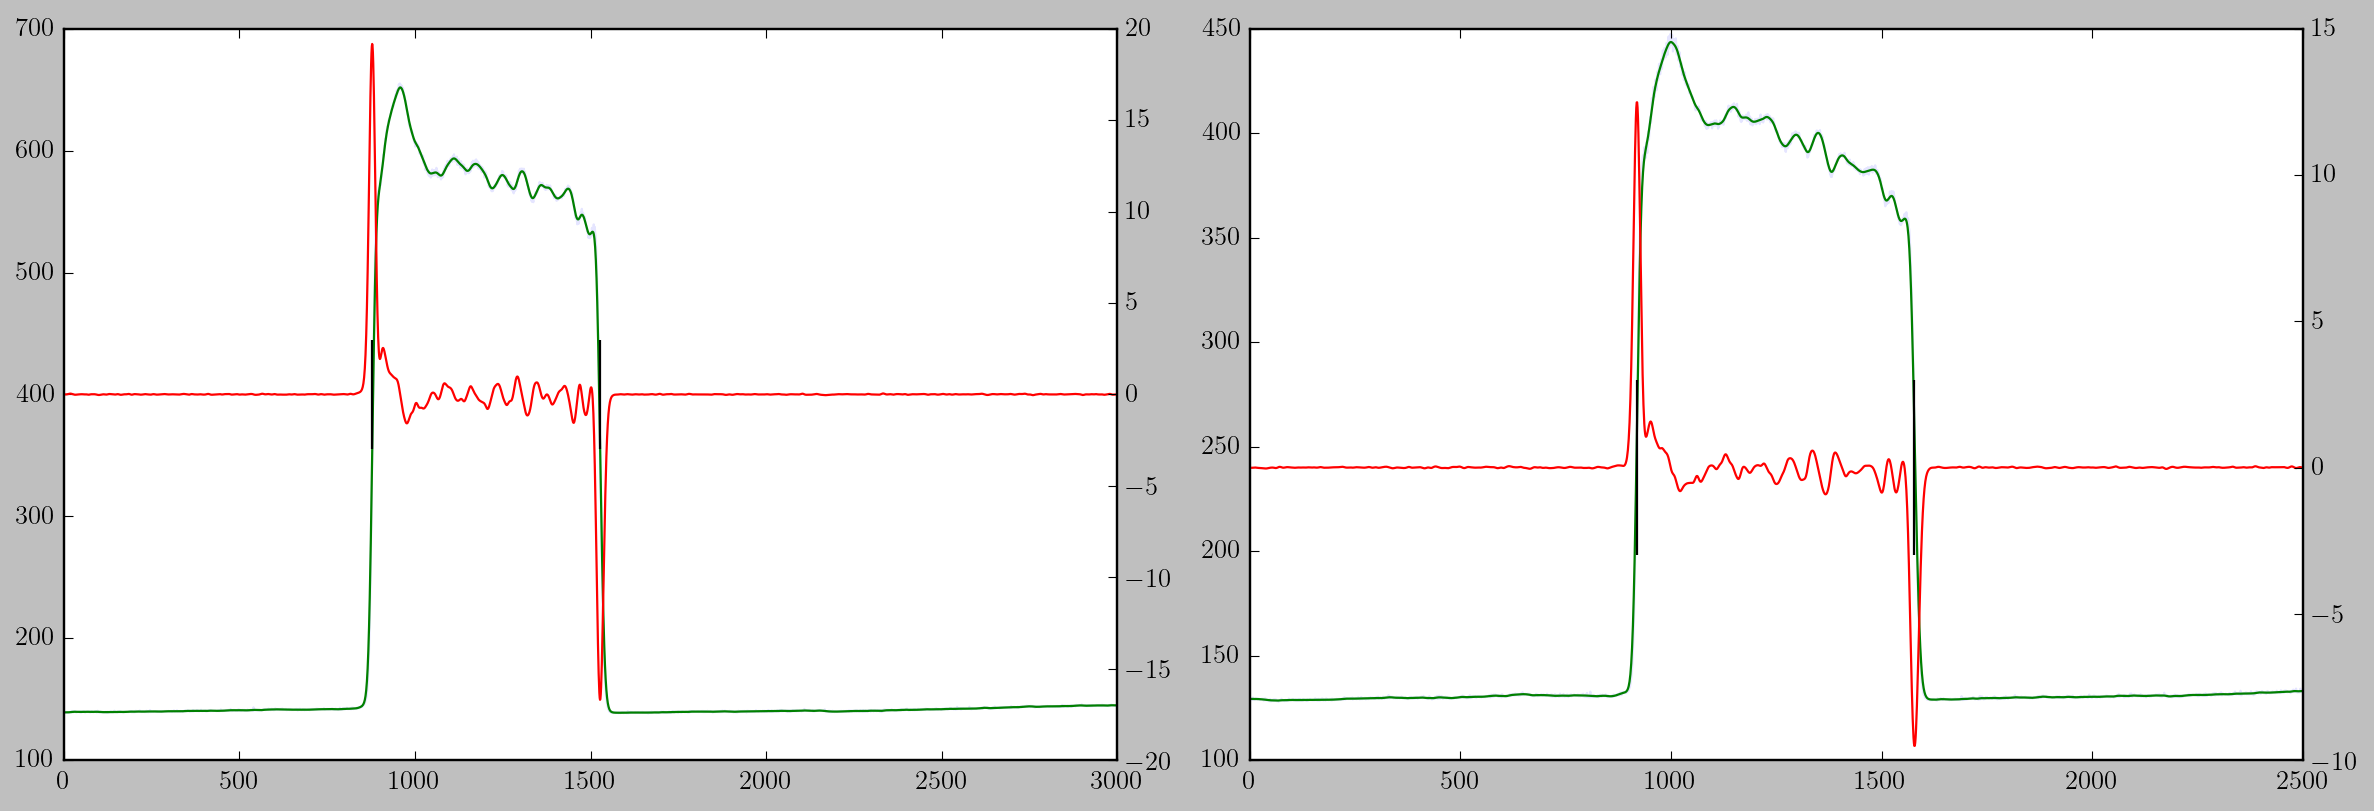

In [9]:
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(221)
plt.plot(lineoutFiducial_bckg_KEPLER1, alpha = 0.1)
plt.plot(lineoutFiducial_filter_bckg_KEPLER1)

ax2 = ax1.twinx()
ax2.plot(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1, 'C2')
plt.vlines(positionLeftEdgeFiducial_KEPLER1, -3, 3)
plt.vlines(positionRightEdgeFiducial_KEPLER1, -3, 3)

ax3 = plt.subplot(222)
plt.plot(lineoutFiducial_bckg_KEPLER2, alpha = 0.1)
plt.plot(lineoutFiducial_filter_bckg_KEPLER2)

ax4 = ax3.twinx()
ax4.plot(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2, 'C2')
plt.vlines(positionLeftEdgeFiducial_KEPLER2, -3, 3)
plt.vlines(positionRightEdgeFiducial_KEPLER2, -3, 3)
plt.tight_layout()
plt.show()

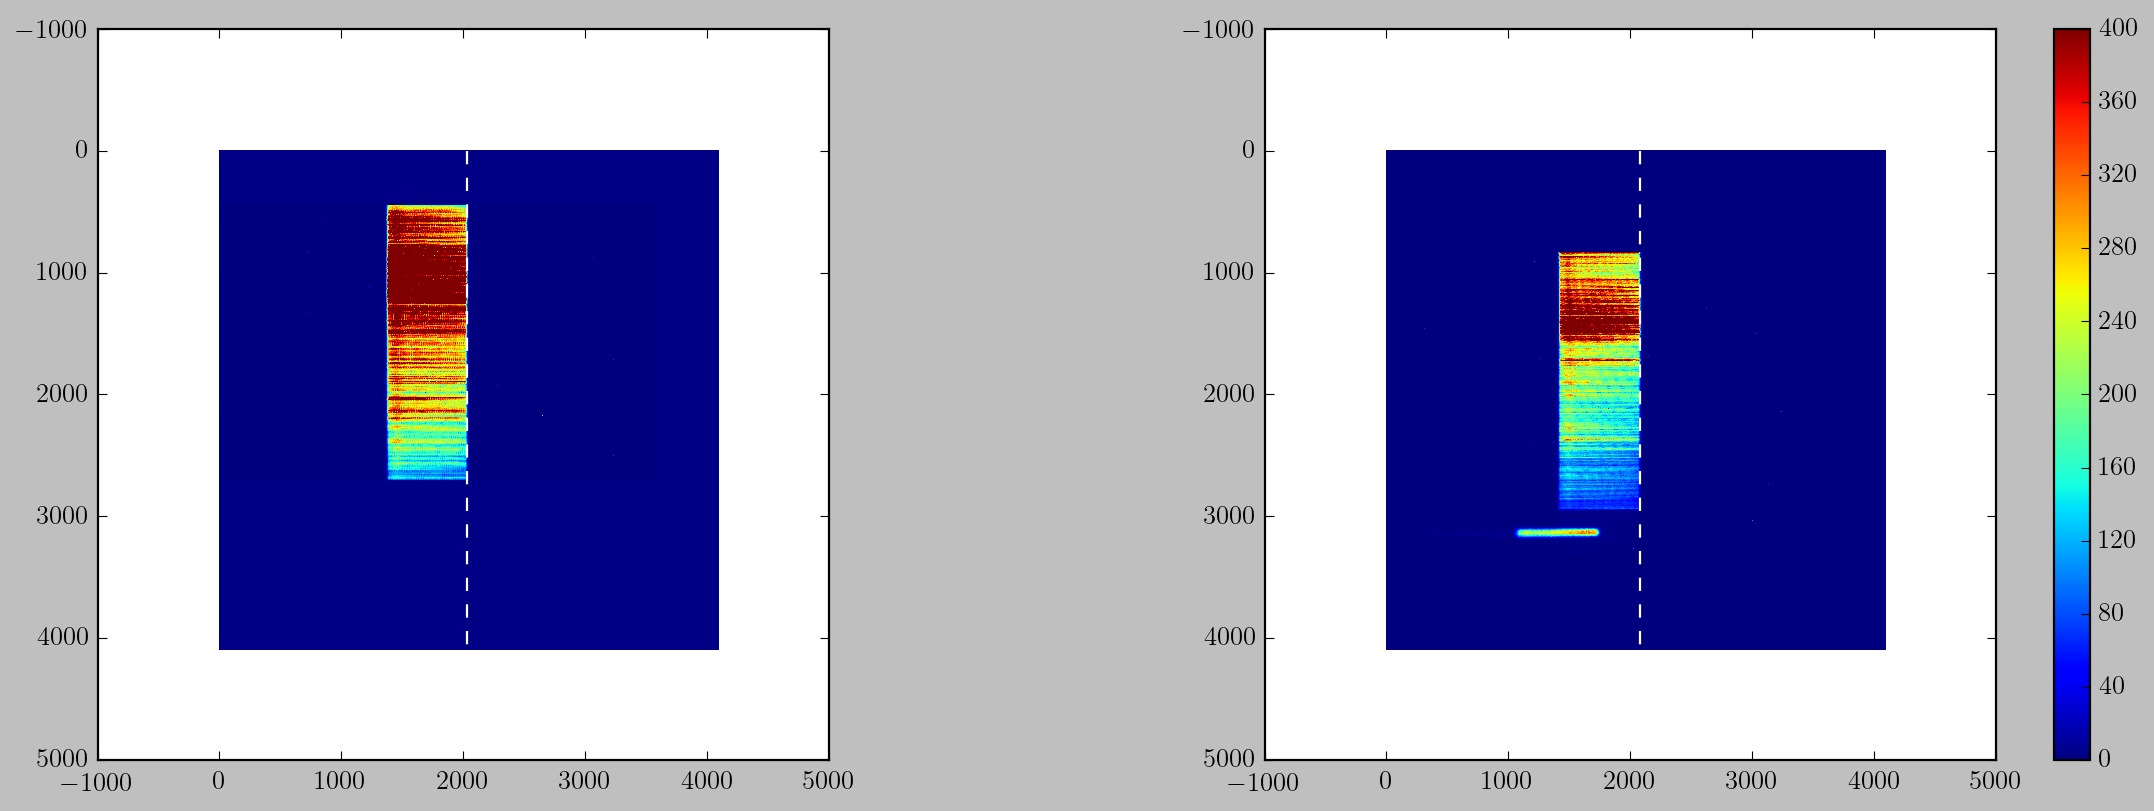

In [10]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_r-imgKEP1_bckg, vmin = 0, vmax = 500, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(500 + positionRightEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')

plt.subplot(222)
plt.imshow(imgKEP2_r-imgKEP2_bckg, vmin = 0, vmax = 400, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER2, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(500 + positionRightEdgeFiducial_KEPLER2, 0, 4095, linestyles='dashed', colors = 'w')
plt.colorbar()
plt.tight_layout()
plt.show()

In [11]:
imgKEP1_DelayScan = []
imgKEP2_DelayScan = []

imgKEP1_RightEdgePosition_DelayScan = []
imgKEP2_RightEdgePosition_DelayScan = []

for i in range(650, 652):
    print(i)
    imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(2740, i)
    imgKEP1_DelayScan += [imgKEP1_r-imgKEP1_bckg]
    imgKEP2_DelayScan += [imgKEP2_r-imgKEP2_bckg]
    
    ## KEPLER1
    lineoutFiducial_bckg_KEPLER1 = np.mean(imgKEP1_r[1000:2500, 500:3500], axis = 0)
    lineoutFiducial_filter_bckg_KEPLER1 = gaussian_filter(lineoutFiducial_bckg_KEPLER1, 5)
    lineoutFiducial_filter_1stDeriv_bckg_KEPLER1 = np.diff(lineoutFiducial_filter_bckg_KEPLER1)

    positionRightEdgeFiducial_KEPLER1 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)
    imgKEP1_RightEdgePosition_DelayScan += [500 + positionRightEdgeFiducial_KEPLER1]
    positionLeftEdgeFiducial_KEPLER1 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER1)
    
    ## KEPLER2  
    lineoutFiducial_bckg_KEPLER2 = np.mean(imgKEP2_r[1000:2500, 500:3500], axis = 0)
    lineoutFiducial_filter_bckg_KEPLER2 = gaussian_filter(lineoutFiducial_bckg_KEPLER2, 5)
    lineoutFiducial_filter_1stDeriv_bckg_KEPLER2 = np.diff(lineoutFiducial_filter_bckg_KEPLER2)

    positionRightEdgeFiducial_KEPLER2 = np.argmin(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)
    imgKEP2_RightEdgePosition_DelayScan += [500 + positionRightEdgeFiducial_KEPLER2]
    positionLeftEdgeFiducial_KEPLER2 = np.argmax(lineoutFiducial_filter_1stDeriv_bckg_KEPLER2)
    
    
    

imgKEP1_DelayScan = np.array(imgKEP1_DelayScan)
imgKEP1_RightEdgePosition_DelayScan = np.array(imgKEP1_RightEdgePosition_DelayScan)

imgKEP2_DelayScan = np.array(imgKEP2_DelayScan)
imgKEP2_RightEdgePosition_DelayScan = np.array(imgKEP2_RightEdgePosition_DelayScan)

650
651


In [26]:
imgKEP2_RightEdgePosition_DelayScan

array([2078, 2773])

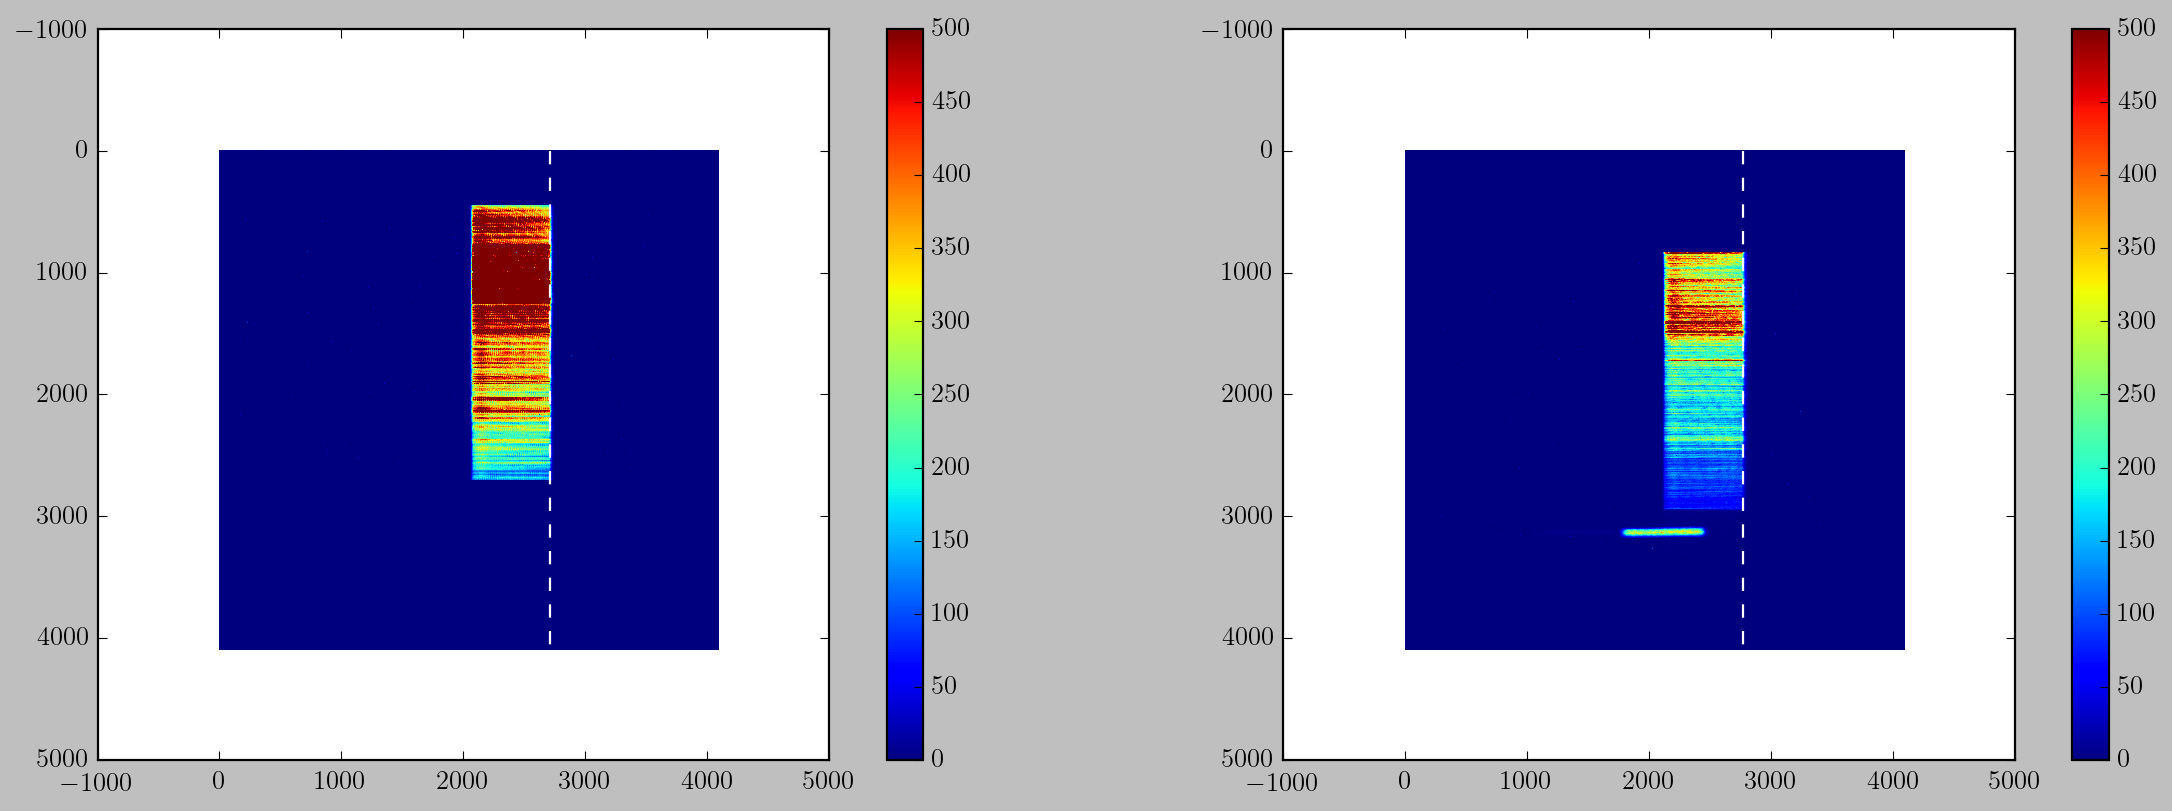

In [25]:
idx = 1
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.imshow(imgKEP1_DelayScan[idx], vmin = 0, vmax = 500, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(imgKEP1_RightEdgePosition_DelayScan[idx], 0, 4095, linestyles='dashed', colors = 'w')
plt.colorbar()

plt.subplot(222)
plt.imshow(imgKEP2_DelayScan[idx], vmin = 0, vmax = 500, cmap = plt.cm.jet)
# plt.vlines(500 + positionLeftEdgeFiducial_KEPLER1, 0, 4095, linestyles='dashed', colors = 'w')
plt.vlines(imgKEP2_RightEdgePosition_DelayScan[idx], 0, 4095, linestyles='dashed', colors = 'w')
plt.colorbar()

plt.tight_layout()
plt.show()

In [13]:
timeDelayDipole = [0, -10]
poptDipole_KEPLER1 = np.polyfit(imgKEP1_RightEdgePosition_DelayScan, timeDelayDipole, 1)
poptDipole_KEPLER2 = np.polyfit(imgKEP2_RightEdgePosition_DelayScan, timeDelayDipole, 1)


In [14]:
poptDipole_KEPLER2

array([-1.43884892e-02,  2.98992806e+01])

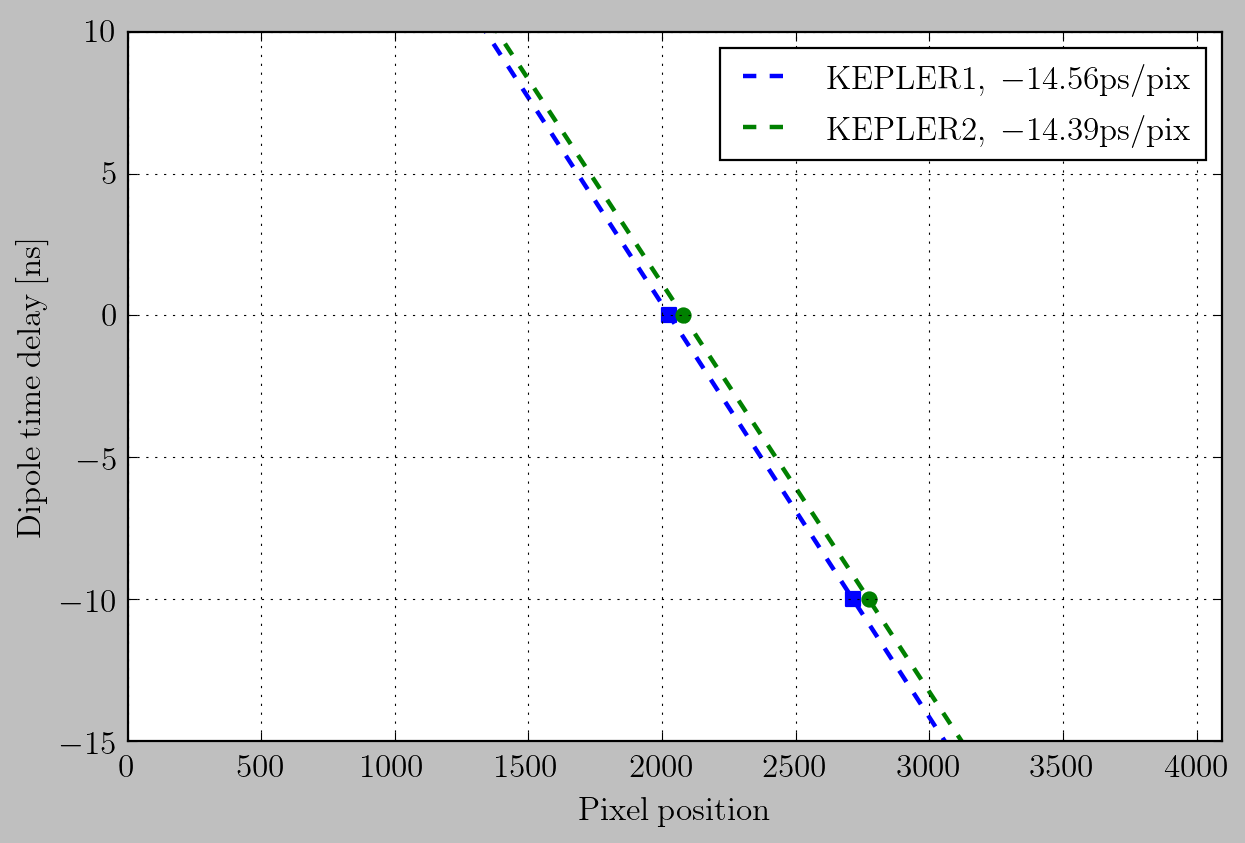

In [15]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.scatter(imgKEP1_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C0', marker = 's', s = 40)
plt.scatter(imgKEP2_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C1', marker = 'o', s = 40)

plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER1[0] + poptDipole_KEPLER1[1], '--C0', lw  =2, label = '$\\rm{KEPLER1, \\: %.2f ps/pix}$'%(poptDipole_KEPLER1[0]*1000))
plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER2[0] + poptDipole_KEPLER2[1], '--C1', lw  =2, label = '$\\rm{KEPLER2, \\: %.2f ps/pix}$'%(poptDipole_KEPLER2[0]*1000))

plt.grid()
plt.legend(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim([0, 4096])
plt.ylim([-15, 10])
plt.xlabel('$\\rm{Pixel \\: position}$', fontsize = 15)
plt.ylabel('$\\rm{Dipole \\: time \\: delay \\: [ns]}$', fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

In [16]:
poptTimedelay_KEPLER1 = np.polyfit(timeDelayDipole, -(imgKEP1_RightEdgePosition_DelayScan - (-poptDipole_KEPLER1[1]/poptDipole_KEPLER1[0]))*14.56e-3, 1)
poptTimedelay_KEPLER2 = np.polyfit(timeDelayDipole, -(imgKEP2_RightEdgePosition_DelayScan - (-poptDipole_KEPLER2[1]/poptDipole_KEPLER2[0]))*14.39e-3, 1)

print(poptTimedelay_KEPLER1, poptTimedelay_KEPLER2)


[ 1.00027200e+00 -3.04426615e-14] [1.00010500e+00 7.08603999e-15]


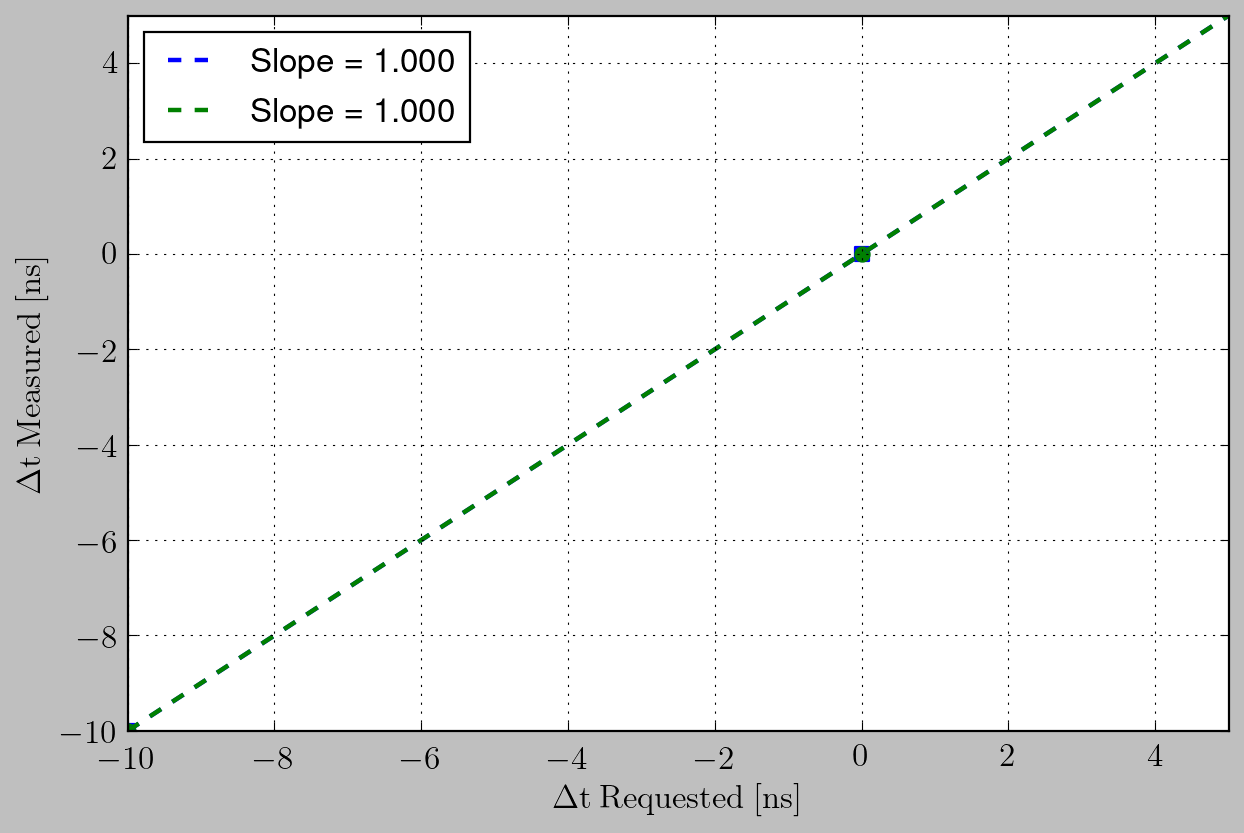

In [18]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.scatter(timeDelayDipole, -(imgKEP1_RightEdgePosition_DelayScan - (-poptDipole_KEPLER1[1]/poptDipole_KEPLER1[0]))*14.56e-3, color = 'C0', marker = 's', s = 40)
plt.scatter(timeDelayDipole, -(imgKEP2_RightEdgePosition_DelayScan - (-poptDipole_KEPLER2[1]/poptDipole_KEPLER2[0]))*14.39e-3, color = 'C1', marker = 'o', s = 40)

plt.plot(np.arange(-10, 7, 1), np.arange(-10, 7, 1)*poptTimedelay_KEPLER1[0] + poptTimedelay_KEPLER1[1], '--C0', lw = 2, label = 'Slope = %.3f'%(poptTimedelay_KEPLER1[0]))
plt.plot(np.arange(-10, 7, 1), np.arange(-10, 7, 1)*poptTimedelay_KEPLER2[0] + poptTimedelay_KEPLER2[1], '--C1', lw = 2, label = 'Slope = %.3f'%(poptTimedelay_KEPLER2[0]))

# plt.scatter(posEdgeDipole, timeDelayDipole, color = 'C2', marker = 's', s = 40)
# plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole[0] + poptDipole[1], '--C2', lw  =2, label = 'Slope = %.2f ps/pix'%(poptDipole[0]*1000))
plt.grid()
plt.legend(loc = 2, fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlabel('$\\rm{\\Delta t \\: Requested \\: [ns]}$', fontsize = 15)
plt.ylabel('$\\rm{\\Delta t \\: Measured \\: [ns]}$', fontsize = 15)
plt.xlim([-10, 5])
plt.ylim([-10, 5])
plt.yticks(fontsize = 15)
plt.tight_layout()
plt.show()

## Timing Diple Fiducial

In [19]:
dipoleFiducial = np.mean((imgKEP2_r-imgKEP2_bckg)[3050:3100, :], axis = 0)
lineoutFiducial_dipoleFiducial = gaussian_filter(dipoleFiducial, 10)
lineoutFiducial_dipoleFiducial_1stDeriv = np.diff(lineoutFiducial_dipoleFiducial)

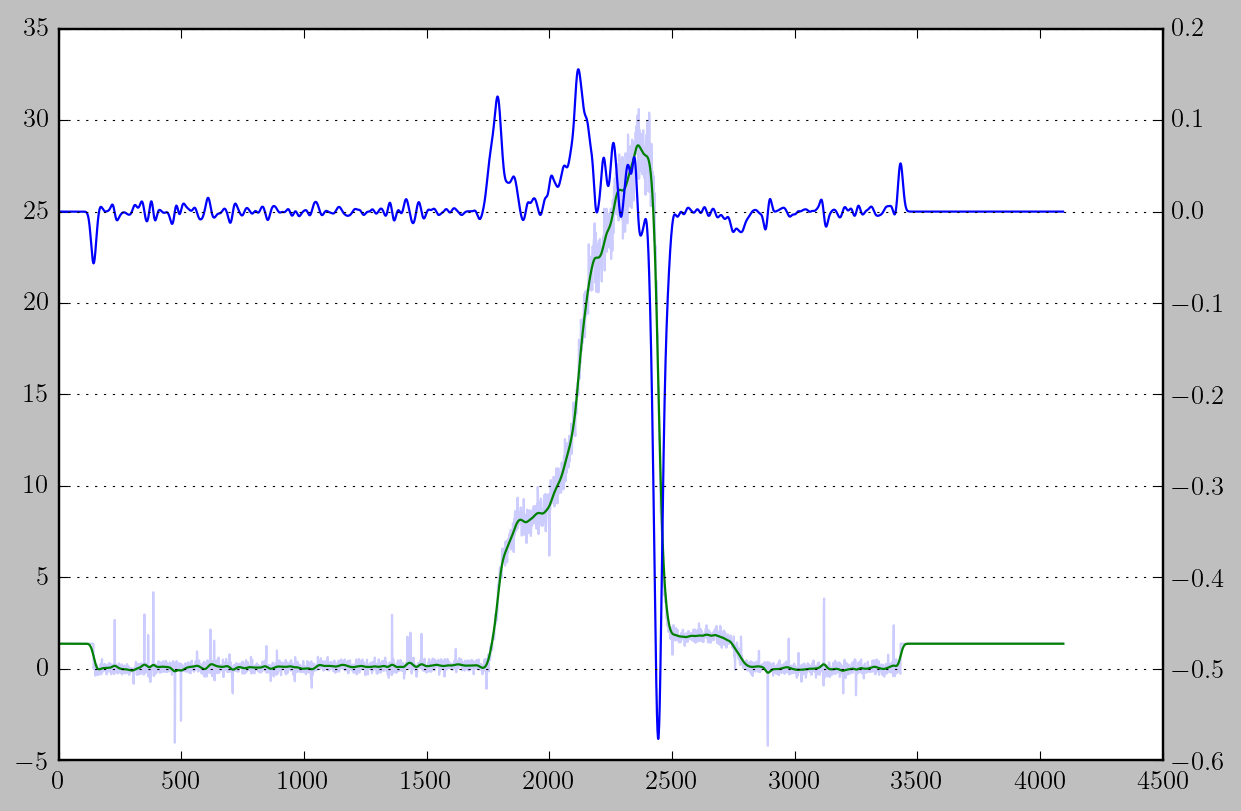

In [20]:
plt.figure(figsize = (15, 10))
ax1 = plt.subplot(221)
plt.plot(dipoleFiducial, alpha = 0.2)
plt.plot(lineoutFiducial_dipoleFiducial)
ax2 = ax1.twinx()
plt.plot(lineoutFiducial_dipoleFiducial_1stDeriv)
# plt.imshow((imgKEP2_r-imgKEP2_bckg)[3050:3100, :])
plt.grid()
plt.tight_layout()
plt.show()

In [21]:


imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan = []


for i in range(650, 652):
    print(i)
    imgKEP1_r, imgKEP2_r  = extraVISARImages_mean(2740, i)

    ## KEPLER2  
    dipoleFiducial = np.mean((imgKEP2_r-imgKEP2_bckg)[3050:3100, :], axis = 0)
    lineoutFiducial_dipoleFiducial = gaussian_filter(dipoleFiducial, 10)
    lineoutFiducial_dipoleFiducial_1stDeriv = np.diff(lineoutFiducial_dipoleFiducial)

    positionRightEdgeDipoleFiducial_KEPLER2 = np.argmin(lineoutFiducial_dipoleFiducial_1stDeriv)
    imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan += [positionRightEdgeDipoleFiducial_KEPLER2]

650
651


In [22]:
imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan

[1741, 2444]

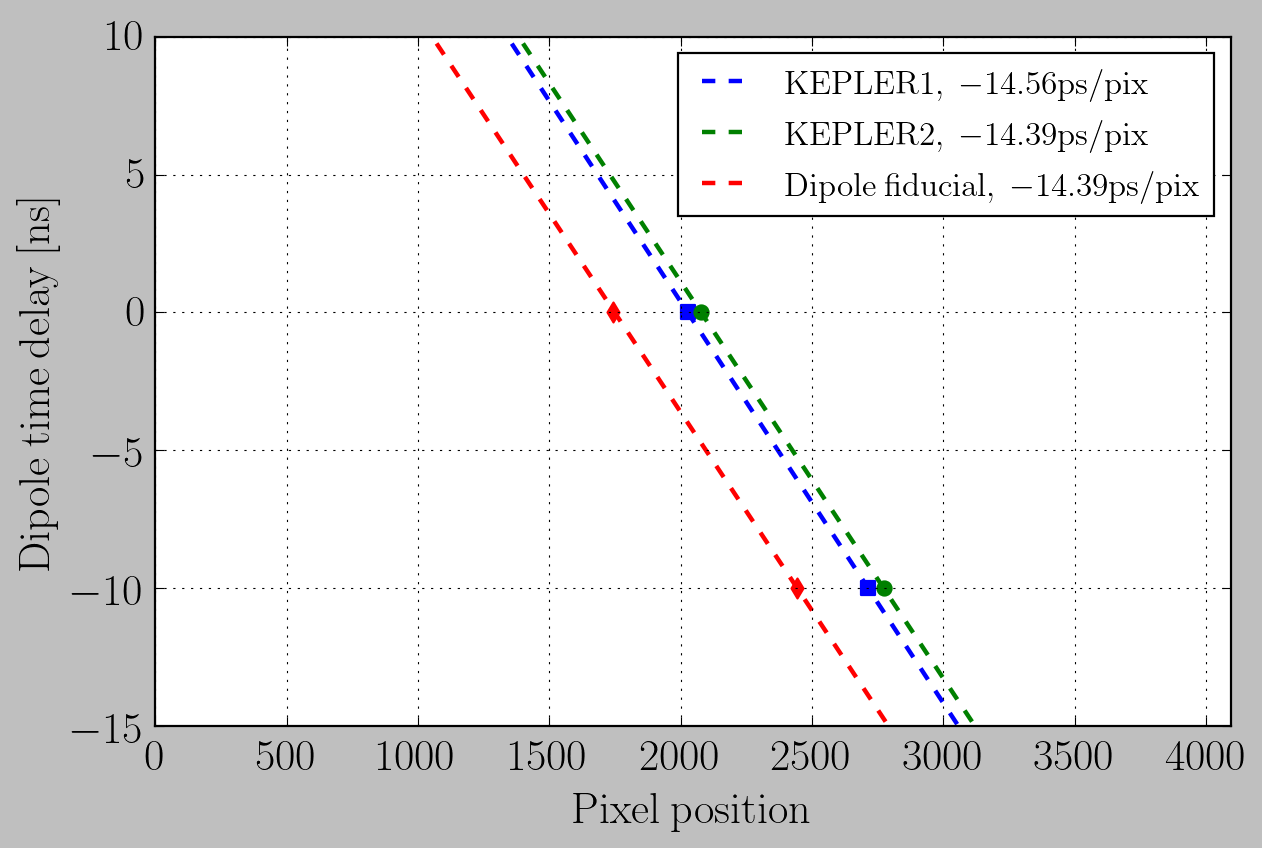

In [27]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.scatter(imgKEP1_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C0', marker = 's', s = 40)
plt.scatter(imgKEP2_RightEdgePosition_DelayScan, timeDelayDipole, color = 'C1', marker = 'o', s = 40)
plt.scatter(imgKEP2_RightEdgePosition_DipoleFiducial_DelayScan, timeDelayDipole, color = 'C2', marker = 'd', s = 40)

plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER1[0] + poptDipole_KEPLER1[1], '--C0', lw  =2, label = '$\\rm{KEPLER1, \\: %.2f ps/pix}$'%(poptDipole_KEPLER1[0]*1000))
plt.plot(np.arange(0, 4500, 10), np.arange(0, 4500, 10)*poptDipole_KEPLER2[0] + poptDipole_KEPLER2[1], '--C1', lw  =2, label = '$\\rm{KEPLER2, \\: %.2f ps/pix}$'%(poptDipole_KEPLER2[0]*1000))

plt.plot(np.arange(0, 4500, 10)-329, np.arange(0, 4500, 10)*poptDipole_KEPLER2[0] + poptDipole_KEPLER2[1], '--C2', lw  =2, label = '$\\rm{Dipole \\:fiducial, \\: %.2f ps/pix}$'%(poptDipole_KEPLER2[0]*1000))


plt.grid()
plt.legend(fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlim([0, 4096])
plt.ylim([-15, 10])
plt.xlabel('$\\rm{Pixel \\: position}$', fontsize = 20)
plt.ylabel('$\\rm{Dipole \\: time \\: delay \\: [ns]}$', fontsize = 20)

plt.tight_layout()
# plt.savefig('./CalibrationTimingDipole.png', dpi = 300)
plt.show()